# Mac Mobile

This is where we will conduct the machine learning experimentation to develop and train an accurate model for classifying when users are standing, sitting, etc.

First we download the latest data sets from github, normalize the data and load them into pandas dataframes

In [17]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import math


def accelerometer_stats(window_frame):
  return {
      "accel_x_avg": window_frame["x-axis (g)"].mean(),
      "accel_x_max": window_frame["x-axis (g)"].max(),
      "accel_x_min": window_frame["x-axis (g)"].min(),
      "accel_x_var": window_frame["x-axis (g)"].var(),
      
      "accel_y_avg": window_frame["y-axis (g)"].mean(),
      "accel_y_max": window_frame["y-axis (g)"].max(),
      "accel_y_min": window_frame["y-axis (g)"].min(),
      "accel_y_var": window_frame["y-axis (g)"].var(),
      
      "accel_z_avg": window_frame["z-axis (g)"].mean(),
      "accel_z_max": window_frame["z-axis (g)"].max(),
      "accel_z_min": window_frame["z-axis (g)"].min(),
      "accel_z_var": window_frame["z-axis (g)"].var(),
      
      "epoch_start": window_frame["epoch (ms)"].min(),
      "epoch_end": window_frame["epoch (ms)"].max(),
      "epoch_length": window_frame["epoch (ms)"].max() - window_frame["epoch (ms)"].min(),
      
      "action": window_frame['state'].apply(state_to_num).value_counts().idxmax()
  }

def gyroscope_stats(window_frame):
  return {
      "gyro_x_avg": window_frame["x-axis (deg/s)"].mean(),
      "gyro_x_max": window_frame["x-axis (deg/s)"].max(),
      "gyro_x_min": window_frame["x-axis (deg/s)"].min(),
      "gyro_x_var": window_frame["x-axis (deg/s)"].var(),
      
      "gyro_y_avg": window_frame["y-axis (deg/s)"].mean(),
      "gyro_y_max": window_frame["y-axis (deg/s)"].max(),
      "gyro_y_min": window_frame["y-axis (deg/s)"].min(),
      "gyro_y_var": window_frame["y-axis (deg/s)"].var(),
      
      "gyro_z_avg": window_frame["z-axis (deg/s)"].mean(),
      "gyro_z_max": window_frame["z-axis (deg/s)"].max(),
      "gyro_z_min": window_frame["z-axis (deg/s)"].min(),
      "gyro_z_var": window_frame["z-axis (deg/s)"].var(),
      
      "epoch_start": window_frame["epoch (ms)"].min(),
      "epoch_end": window_frame["epoch (ms)"].max(),
      "epoch_length": window_frame["epoch (ms)"].max() - window_frame["epoch (ms)"].min(),
      
      # For now we randomly assign an action the user is doing until we can capture and label our own data
      "action": window_frame["state"].apply(state_to_num).value_counts().idxmax()
  }

def state_to_num(state):
  if state == "standing":
    return 3
  if state == "sitting":
    return 0
  if state == "layingdown" or state == "lyingdown":
    return 1
  if state == "walking":
    return 2
  if state == "unknown":
    return 4
  return -1

def windows(d, w, t):
  r = np.arange(len(d))
  s = r[::t]
  z = list(zip(s, s + w))
  f = '{0[0]}:{0[1]}'.format
  g = lambda t: d.iloc[t[0]:t[1]]
  return pd.concat(map(g, z), keys=map(f, z))
  
def windowify2(size, step, dataset):
  frequency_hz = 1000/25
  window_size_in_elements = math.ceil(size / frequency_hz)
  window_step_in_elements = math.ceil(step / frequency_hz)
  
  return windows(dataset, window_size_in_elements, window_step_in_elements)

def preprocess_accel_data(df):
  processed = ""
  #df = df.sort_values(by=['epoch (ms)'])
  df[['x-axis (g)','y-axis (g)','z-axis (g)']] = df[['x-axis (g)','y-axis (g)','z-axis (g)']].apply(pd.to_numeric)
  testing2 = preprocessing.normalize(df[['x-axis (g)','y-axis (g)','z-axis (g)']])
  testing_data = np.concatenate((df[['epoch (ms)', 'elapsed (s)', 'state']], testing2), axis=1)
  testing = pd.DataFrame(data=testing_data[0:,0:],    # values
            index=[i for i in range(1, len(testing_data) + 1)],    # 1st column as index
            columns=['epoch (ms)', 'elapsed (s)', 'state', 'x-axis (g)','y-axis (g)','z-axis (g)'])
  testing = windowify2(2500, 500, testing)
  p = []
  for group_name, window in testing.groupby(level=0):
    p.append(accelerometer_stats(window))
  processed = pd.DataFrame(p)
  return processed

def load_accel_data(root, files):
  df = preprocess_accel_data(pd.read_csv(root + files[0]))
  for i in range(1, len(files)):
    df = df.append(preprocess_accel_data(pd.read_csv(root + files[i])))
  df = df.sort_values(by=['epoch_start'])
  df.dropna(inplace=True)
  return df

def preprocess_gyro_data(df):
  processed = ""
  #df = df.sort_values(by=['epoch (ms)'])
  df[['x-axis (deg/s)', 'y-axis (deg/s)', 'z-axis (deg/s)']] = df[['x-axis (deg/s)', 'y-axis (deg/s)', 'z-axis (deg/s)']].apply(pd.to_numeric)
  testing2 = preprocessing.normalize(df[['x-axis (deg/s)', 'y-axis (deg/s)', 'z-axis (deg/s)']])
  testing_data = np.concatenate((df[['epoch (ms)', 'elapsed (s)', 'state']], testing2), axis=1)
  testing = pd.DataFrame(data=testing_data[0:,0:],    # values
            index=[i for i in range(1, len(testing_data) + 1)],    # 1st column as index
            columns=['epoch (ms)', 'elapsed (s)', 'state', 'x-axis (deg/s)','y-axis (deg/s)','z-axis (deg/s)'])
  testing = windowify2(2500, 500, testing)
  p = []
  for group_name, window in testing.groupby(level=0):
    p.append(gyroscope_stats(window))
  processed = pd.DataFrame(p)
  return processed

def load_gyro_data(root, files):
  df = preprocess_gyro_data(pd.read_csv(root + files[0]))
  for i in range(1, len(files)):
    df = df.append(preprocess_gyro_data(pd.read_csv(root + files[i])))
  df = df.sort_values(by=['epoch_start'])
  df.dropna(inplace=True)
  return df
  

root = "https://raw.githubusercontent.com/pgunasekara/4zp6/master/machine_learning/training_sets/tagged_sets/"
start_accel_files_list = ["round-1/start/accel/cesar-test1-accel-start.csv",
                          "round-1/start/accel/berto-test1-accel-start.csv",
                          "round-1/start/accel/rebecca-test1-accel-start-out.csv",
                          #"round-2/start/accel/new-berto-test-1-accel-start.csv",
                          "round-2/start/accel/new-berto-test-2-accel-start.csv",
                          "round-2/start/accel/new-berto-test-3-accel-start.csv",
                          "round-2/start/accel/new-berto-test-4-accel-start.csv",
                          "round-2/start/accel/new-pasi-test-5-accel-start.csv",
                          "round-2/start/accel/new-pasi-test-6-accel-start.csv",
                          "round-2/start/accel/new-berto-test-7-accel-start.csv",
                          "round-2/start/accel/new-pasi-test-8-accel-start.csv",
                          "round-2/start/accel/new-berto-test-9-accel-start.csv",
                          "round-2/start/accel/new-pasi-test-10-accel-start.csv",
                         ]
start_gyro_files_list = ["round-1/start/gyro/cesar-test1-gyro-start.csv",
                         "round-1/start/gyro/berto-test1-gyro-start.csv",
                         "round-1/start/gyro/rebecca-test1-gyro-start-out.csv",
                         #"round-2/start/gyro/new-berto-test-1-gyro-start.csv",
                         "round-2/start/gyro/new-berto-test-2-gyro-start.csv",
                         "round-2/start/gyro/new-berto-test-3-gyro-start.csv",
                         "round-2/start/gyro/new-berto-test-4-gyro-start.csv",
                         "round-2/start/gyro/new-pasi-test-5-gyro-start.csv",
                         "round-2/start/gyro/new-pasi-test-6-gyro-start.csv",
                         "round-2/start/gyro/new-berto-test-7-gyro-start.csv",
                         "round-2/start/gyro/new-pasi-test-8-gyro-start.csv",
                         "round-2/start/gyro/new-berto-test-9-gyro-start.csv",
                         "round-2/start/gyro/new-pasi-test-10-gyro-start.csv",
                        ]
complete_accel_files_list = ["round-1/complete/accel/cesar-test1-accel-complete.csv",
                             "round-1/complete/accel/berto-test1-accel-complete.csv",
                             "round-1/complete/accel/rebecca-test1-accel-complete-out.csv",
                             "round-2/complete/accel/new-berto-test-1-accel-complete.csv",
                             "round-2/complete/accel/new-berto-test-2-accel-complete.csv",
                             "round-2/complete/accel/new-berto-test-3-accel-complete.csv",
                             "round-2/complete/accel/new-berto-test-4-accel-complete.csv",
                             "round-2/complete/accel/new-pasi-test-5-accel-complete.csv",
                             "round-2/complete/accel/new-pasi-test-6-accel-complete.csv",
                             "round-2/complete/accel/new-berto-test-7-accel-complete.csv",
                             "round-2/complete/accel/new-pasi-test-8-accel-complete.csv",
                             "round-2/complete/accel/new-berto-test-9-accel-complete.csv",
                             "round-2/complete/accel/new-pasi-test-10-accel-complete.csv",
                            ]
complete_gyro_files_list = ["round-1/complete/gyro/cesar-test1-gyro-complete.csv",
                            "round-1/complete/gyro/berto-test1-gyro-complete.csv",
                            "round-1/complete/gyro/rebecca-test1-gyro-complete-out.csv",
                            "round-2/complete/gyro/new-berto-test-1-gyro-complete.csv",
                            "round-2/complete/gyro/new-berto-test-2-gyro-complete.csv",
                            "round-2/complete/gyro/new-berto-test-3-gyro-complete.csv",
                            "round-2/complete/gyro/new-berto-test-4-gyro-complete.csv",
                            "round-2/complete/gyro/new-pasi-test-5-gyro-complete.csv",
                            "round-2/complete/gyro/new-pasi-test-6-gyro-complete.csv",
                            "round-2/complete/gyro/new-berto-test-7-gyro-complete.csv",
                            "round-2/complete/gyro/new-pasi-test-8-gyro-complete.csv",
                            "round-2/complete/gyro/new-berto-test-9-gyro-complete.csv",
                            "round-2/complete/gyro/new-pasi-test-10-gyro-complete.csv",
                           ]

"""
#######OLD STUFF######

def create_training_set(root,files):
  df = pd.read_csv(root+files[0])
  #display(testing)
  for i in range(1,len(files)):
    df = df.append(pd.read_csv(root+files[i]))
  return df

#Load accelerometer data
display("Accelerometer data")
accelerometer_csv = create_training_set(root,start_accel_files_list)

accelerometer_csv = accelerometer_csv.sort_values(by=['epoch (ms)'])
accel2 = preprocessing.normalize(accelerometer_csv[['x-axis (g)','y-axis (g)','z-axis (g)']])
accelerometer_data = np.concatenate((accelerometer_csv[['epoch (ms)', 'elapsed (s)', 'state']], accel2), axis=1)
accelerometer_csv = pd.DataFrame(data=accelerometer_data[0:,0:],    # values
              index=[i for i in range(1, len(accelerometer_data) + 1)],    # 1st column as index
              columns=['epoch (ms)', 'elapsed (s)', 'state', 'x-axis (g)','y-axis (g)','z-axis (g)'])
display(accelerometer_csv['epoch (ms)'].count())
display(accelerometer_csv.head(10))

#Load ambient light data
#display("Light data")
#ambient_light_csv = pd.read_csv("/content/drive/My Drive/macmobile_data/Sample Data_Ambient Light_2018-07-31T16-03-06.231.csv")
#display(ambient_light_csv.head(10))

#Load gyroscope data
display("Gyroscope data")
gyroscope_csv = create_training_set(root,start_gyro_files_list)
gyroscope_csv = gyroscope_csv.sort_values(by=['epoch (ms)'])
gyro2 = preprocessing.normalize(gyroscope_csv[['x-axis (deg/s)', 'y-axis (deg/s)', 'z-axis (deg/s)']])
gyroscope_data = np.concatenate((gyroscope_csv[['epoch (ms)', 'elapsed (s)', 'state']], gyro2), axis=1)
gyroscope_csv = pd.DataFrame(data=gyroscope_data[0:,0:],    # values
              index=[i for i in range(1, len(gyroscope_data) + 1)],    # 1st column as index
              columns=['epoch (ms)', 'elapsed (s)', 'state', 'x-axis (deg/s)','y-axis (deg/s)','z-axis (deg/s)'])
display(gyroscope_csv['epoch (ms)'].count())
display(gyroscope_csv.head(10))
#accelerometer_csv['x-axis (°/s)'] = preprocessing.normalize(accelerometer_csv['x-axis (°/s)'])
#accelerometer_csv['y-axis (°/s)'] = preprocessing.normalize(accelerometer_csv['y-axis (°/s)'])
#accelerometer_csv['z-axis (°/s)'] = preprocessing.normalize(accelerometer_csv['z-axis (°/s)'])

#Load magnetometer data
#display("Magnetometer data")
#magnetometer_csv = pd.read_csv("/content/drive/My Drive/macmobile_data/Sample Data_Magnetometer_2018-07-31T16-03-06.231.csv")
#display(magnetometer_csv.head(10))

#Load pressure data
#display("Pressure data")
#pressure_csv = pd.read_csv("/content/drive/My Drive/macmobile_data/Sample Data_Pressure_2018-07-31T16-03-06.231.csv")
#display(pressure_csv.head(10))

#Load temperature data
#display("Temperature data")
#temperature_csv = pd.read_csv("/content/drive/My Drive/macmobile_data/Sample Data_Temperature_2018-07-31T16-03-06.231.csv")
#display(temperature_csv.head(10))
"""

'\n#######OLD STUFF######\n\ndef create_training_set(root,files):\n  df = pd.read_csv(root+files[0])\n  #display(testing)\n  for i in range(1,len(files)):\n    df = df.append(pd.read_csv(root+files[i]))\n  return df\n\n#Load accelerometer data\ndisplay("Accelerometer data")\naccelerometer_csv = create_training_set(root,start_accel_files_list)\n\naccelerometer_csv = accelerometer_csv.sort_values(by=[\'epoch (ms)\'])\naccel2 = preprocessing.normalize(accelerometer_csv[[\'x-axis (g)\',\'y-axis (g)\',\'z-axis (g)\']])\naccelerometer_data = np.concatenate((accelerometer_csv[[\'epoch (ms)\', \'elapsed (s)\', \'state\']], accel2), axis=1)\naccelerometer_csv = pd.DataFrame(data=accelerometer_data[0:,0:],    # values\n              index=[i for i in range(1, len(accelerometer_data) + 1)],    # 1st column as index\n              columns=[\'epoch (ms)\', \'elapsed (s)\', \'state\', \'x-axis (g)\',\'y-axis (g)\',\'z-axis (g)\'])\ndisplay(accelerometer_csv[\'epoch (ms)\'].count())\ndisplay(accelero

This code breaks our data down into windows of size `size`, moving `step` milliseconds after each window. In our particular case, we are use 2.5 second windows moving 0.5 seconds at a time. Afterwards, we have a merging function that merges the accelerometer and gyroscope windows where they best fit.

In [0]:
import sys
"""
#### OLD STUFF####
def windowify(size, step, dataset, stats_func):
  # Get the first timestamp
  start = dataset['epoch (ms)'].iloc[0]
  
  #index of the starting timestamp
  start_index = 0
  
  #index of the beginning of the next step
  step_index = 0
  
  #current index
  i = 0
  
  #stores all the windows
  windows = []
  
  #length of the dataset
  dataset_length = dataset['epoch (ms)'].count()
  
  while i < dataset_length:
    optimal_step = start + step
    min_step_distance = sys.maxsize
    #while we haven't reached the end of the dataset and we still have no completed an entire window
    while i < dataset_length and start + size >= dataset['epoch (ms)'].iloc[i]:
      
      #Find the closest entry to where the step _would_ be
      if abs(optimal_step - dataset['epoch (ms)'].iloc[i]) < min_step_distance:
        step_index = i
        min_step_distance = abs(optimal_step - dataset['epoch (ms)'].iloc[i])
      i += 1
    
    #we have a window of duration size that starts at index start_index and ends at i
    window_frame = dataset[start_index:i]
    
    #calculate some information about the window and store it
    windows.append(stats_func(window_frame))
    
    if i == dataset_length:
      break
      
    if dataset['epoch (ms)'].iloc[i] - dataset['epoch (ms)'].iloc[i-1] > size * 2:
      step_index = i + 1

    #start the next window
    i = step_index
    start_index = step_index
    start = dataset['epoch (ms)'].iloc[i]
    
  return windows
  
"""

def is_contained_by(absorbing_row,merging_row):
  return absorbing_row['epoch_start'] < merging_row['epoch_start'] and \
    absorbing_row['epoch_end'] > merging_row['epoch_end']

def get_merge_distance(absorbing_row,merging_row):
  start_dist = abs(absorbing_row['epoch_start'] - merging_row['epoch_start'])
  end_dist = abs(absorbing_row['epoch_end'] - merging_row['epoch_end'])
  return start_dist + end_dist
  
def merge_rows(absorbing_row,merging_row):
  return absorbing_row[['action','epoch_start','epoch_length','epoch_end']].astype('int64').append(merging_row[4:]).to_dict()

def build_mergeable_dataframes(df1,df2):
  res = []
  df1_ptr,df2_ptr = 0,0
  while df2_ptr < df2['epoch_start'].count():
    row_to_merge = df2.iloc[df2_ptr]
    if is_contained_by(df1.iloc[df1_ptr],row_to_merge):
      res.append(merge_rows(df1.iloc[df1_ptr],row_to_merge))
    else:
      #display(df1_ptr,df2_ptr,df1['epoch_start'].count())
      distToPrev = get_merge_distance(df1.iloc[df1_ptr],row_to_merge)
      nxt_ptr = df1_ptr + 1 if df1_ptr + 1 < df1['epoch_start'].count() else df1_ptr
      distToNext = get_merge_distance(df1.iloc[nxt_ptr],row_to_merge)
      
      if distToPrev < distToNext:
        res.append(merge_rows(df1.iloc[df1_ptr],row_to_merge))
      else:
        res.append(merge_rows(df1.iloc[nxt_ptr],row_to_merge))
        df1_ptr=nxt_ptr
    df2_ptr += 1
  return res

def performMerge(df1,df2):
  mergeable_series_lst = build_mergeable_dataframes(df1,df2)
  mergeable_df = pd.DataFrame.from_records(mergeable_series_lst)
  typecast_map = {"epoch_end":"int64","epoch_start":"int64","action":"int64","epoch_length":"int64"}
  for i in typecast_map.keys():
    mergeable_df[i] = mergeable_df[i].astype(typecast_map[i])

  return pd.merge(df1,mergeable_df,on=['epoch_start','epoch_end','action','epoch_length'])
      
    

User actions are defined as follows:


*   0: Sitting
*   1: Lying in bed
*   2: Walking
*   3: Standing
*   4: Unknown



In [15]:
from random import randint

"""
#####OLD STUFF#####

def accelerometer_stats(window_frame):
  return {
      "accel_x_avg": window_frame["x-axis (g)"].mean(),
      "accel_x_max": window_frame["x-axis (g)"].max(),
      "accel_x_min": window_frame["x-axis (g)"].min(),
      "accel_x_var": window_frame["x-axis (g)"].var(),
      
      "accel_y_avg": window_frame["y-axis (g)"].mean(),
      "accel_y_max": window_frame["y-axis (g)"].max(),
      "accel_y_min": window_frame["y-axis (g)"].min(),
      "accel_y_var": window_frame["y-axis (g)"].var(),
      
      "accel_z_avg": window_frame["z-axis (g)"].mean(),
      "accel_z_max": window_frame["z-axis (g)"].max(),
      "accel_z_min": window_frame["z-axis (g)"].min(),
      "accel_z_var": window_frame["z-axis (g)"].var(),
      
      "epoch_start": window_frame["epoch (ms)"].min(),
      "epoch_end": window_frame["epoch (ms)"].max(),
      "epoch_length": window_frame["epoch (ms)"].max() - window_frame["epoch (ms)"].min(),
      
      "action": window_frame['state'].apply(state_to_num).value_counts().idxmax()
  }

def gyroscope_stats(window_frame):
  return {
      "gyro_x_avg": window_frame["x-axis (deg/s)"].mean(),
      "gyro_x_max": window_frame["x-axis (deg/s)"].max(),
      "gyro_x_min": window_frame["x-axis (deg/s)"].min(),
      "gyro_x_var": window_frame["x-axis (deg/s)"].var(),
      
      "gyro_y_avg": window_frame["y-axis (deg/s)"].mean(),
      "gyro_y_max": window_frame["y-axis (deg/s)"].max(),
      "gyro_y_min": window_frame["y-axis (deg/s)"].min(),
      "gyro_y_var": window_frame["y-axis (deg/s)"].var(),
      
      "gyro_z_avg": window_frame["z-axis (deg/s)"].mean(),
      "gyro_z_max": window_frame["z-axis (deg/s)"].max(),
      "gyro_z_min": window_frame["z-axis (deg/s)"].min(),
      "gyro_z_var": window_frame["z-axis (deg/s)"].var(),
      
      "epoch_start": window_frame["epoch (ms)"].min(),
      "epoch_end": window_frame["epoch (ms)"].max(),
      "epoch_length": window_frame["epoch (ms)"].max() - window_frame["epoch (ms)"].min(),
      
      # For now we randomly assign an action the user is doing until we can capture and label our own data
      "action": window_frame["state"].apply(state_to_num).value_counts().idxmax()
  }

def state_to_num(state):
  if state == "standing":
    return 3
  if state == "sitting":
    return 0
  if state == "layingdown" or state == "lyingdown":
    return 1
  if state == "walking":
    return 2
  if state == "unknown":
    return 4
  return -1
  
"""

'\n#####OLD STUFF#####\n\ndef accelerometer_stats(window_frame):\n  return {\n      "accel_x_avg": window_frame["x-axis (g)"].mean(),\n      "accel_x_max": window_frame["x-axis (g)"].max(),\n      "accel_x_min": window_frame["x-axis (g)"].min(),\n      "accel_x_var": window_frame["x-axis (g)"].var(),\n      \n      "accel_y_avg": window_frame["y-axis (g)"].mean(),\n      "accel_y_max": window_frame["y-axis (g)"].max(),\n      "accel_y_min": window_frame["y-axis (g)"].min(),\n      "accel_y_var": window_frame["y-axis (g)"].var(),\n      \n      "accel_z_avg": window_frame["z-axis (g)"].mean(),\n      "accel_z_max": window_frame["z-axis (g)"].max(),\n      "accel_z_min": window_frame["z-axis (g)"].min(),\n      "accel_z_var": window_frame["z-axis (g)"].var(),\n      \n      "epoch_start": window_frame["epoch (ms)"].min(),\n      "epoch_end": window_frame["epoch (ms)"].max(),\n      "epoch_length": window_frame["epoch (ms)"].max() - window_frame["epoch (ms)"].min(),\n      \n      "action

Here we process all of the data into windows and merge the accelerometer and gyroscope windows into one big data set.

In [18]:
import time

"""
##########OLD STUFF#############

start_time = time.time()
accelerometer_windows = windowify(2500, 500, accelerometer_csv, accelerometer_stats)
accel_df = pd.DataFrame.from_records(accelerometer_windows)
#display(accel_df.head(10))
gyroscope_windows = windowify(2500, 500, gyroscope_csv, gyroscope_stats)
gyro_df = pd.DataFrame.from_records(gyroscope_windows)
elapsed_time = time.time() - start_time
display(elapsed_time)
display(gyro_df.head(10))
display(accel_df['epoch_start'].count())
display(gyro_df['epoch_start'].count())
"""

#start_time = time.time()
accel_df = load_accel_data(root, start_accel_files_list)
gyro_df = load_gyro_data(root, start_gyro_files_list)
#elapsed_time = time.time() - start_time
#display(elapsed_time)
display(accel_df.head(10))
display(accel_df['epoch_start'].count())
display(gyro_df.head(10))
display(gyro_df['epoch_start'].count())


#mergeable_series_lst = build_mergeable_dataframes(accel_df.head(10),gyro_df.head(10))
#mergeable_series_lst = build_mergeable_dataframes(accel_df,gyro_df)
#mergeable_df = pd.DataFrame.from_records(mergeable_series_lst)
#typecast_map = {"epoch_end":"int64","epoch_start":"int64","action":"int64","epoch_length":"int64"}
#for i in typecast_map.keys():
#  mergeable_df[i] = mergeable_df[i].astype(typecast_map[i])
  
#accel_gyro_df = pd.merge(accel_df,mergeable_df,on=['epoch_start','epoch_end','action','epoch_length'])
accel_gyro_df = performMerge(accel_df,gyro_df)

display(accel_gyro_df.columns)
#display(accel_gyro_df[['epoch_start','epoch_end','accel_x_avg','gyro_x_avg']])
display(accel_gyro_df.head(10))
display(accel_gyro_df['epoch_start'].count())

,accel_x_avg,accel_x_max,accel_x_min,accel_x_var,accel_y_avg,accel_y_max,accel_y_min,accel_y_var,accel_z_avg,accel_z_max,accel_z_min,accel_z_var,action,epoch_end,epoch_length,epoch_start
0,0.159138,0.234144,0.088988,0.000618,-0.969768,-0.947678,-0.979520,3.279829e-05,0.181869,0.254380,0.152522,0.000517,3,1542812669994,2421,1542812667573
35,0.158557,0.234144,0.088988,0.000596,-0.969419,-0.947678,-0.979520,3.113414e-05,0.184385,0.254380,0.152522,0.000479,3,1542812670621,2576,1542812668045
146,0.155101,0.183332,0.088988,0.000241,-0.970612,-0.958764,-0.979520,1.207979e-05,0.182566,0.244460,0.152522,0.000281,3,1542812671107,2566,1542812668541
257,0.158837,0.179128,0.141078,0.000046,-0.970036,-0.960780,-0.976552,5.964726e-06,0.183465,0.220205,0.162079,0.000091,3,1542812671568,2420,1542812669148
339,0.159664,0.171096,0.141078,0.000033,-0.969668,-0.966954,-0.972936,2.070163e-06,0.184913,0.193310,0.170310,0.000025,3,1542812672177,2543,1542812669634
350,0.162053,0.171096,0.154163,0.000013,-0.968936,-0.966819,-0.971058,1.014627e-06,0.186744,0.193310,0.177719,0.000015,3,1542812672658,2542,1542812670116
361,0.162933,0.172314,0.154163,0.000014,-0.968488,-0.965468,-0.970933,1.161047e-06,0.188295,0.196191,0.177719,0.000014,3,1542812673142,2374,1542812670768
372,0.163861,0.172314,0.154163,0.000012,-0.968003,-0.965468,-0.969781,7.728488e-07,0.189997,0.196191,0.183324,0.000008,3,1542812673762,2556,1542812671206
5,0.162105,0.172314,0.147391,0.000034,-0.968339,-0.965468,-0.971515,1.861812e-06,0.189725,0.196833,0.182292,0.000011,3,1542812674234,2541,1542812671693
16,0.158889,0.172314,0.134034,0.000077,-0.969100,-0.965468,-0.975353,4.929553e-06,0.188402,0.196833,0.175275,0.000023,3,1542812674740,2440,1542812672300


7068

,action,epoch_end,epoch_length,epoch_start,gyro_x_avg,gyro_x_max,gyro_x_min,gyro_x_var,gyro_y_avg,gyro_y_max,gyro_y_min,gyro_y_var,gyro_z_avg,gyro_z_max,gyro_z_min,gyro_z_var
0,3,1542812669870,2421,1542812667449,0.046991,0.909740,-0.795273,0.109553,-0.013505,0.990044,-0.988045,0.666019,-0.001481,0.934011,-0.932445,0.238126
35,3,1542812670503,2569,1542812667934,0.042190,0.856731,-0.795273,0.116435,-0.113401,0.990044,-0.996475,0.647191,0.093231,0.934011,-0.932445,0.228795
146,3,1542812670985,2567,1542812668418,0.171431,0.856731,-0.795273,0.167084,-0.078202,0.990044,-0.996475,0.590006,-0.072593,0.829561,-0.932445,0.217608
257,3,1542812671449,2424,1542812669025,0.218175,0.999055,-0.518476,0.151276,-0.177618,0.990044,-0.996475,0.548300,0.067519,0.912871,-0.879049,0.231496
339,3,1542812672060,2528,1542812669532,0.287606,0.999055,-0.518476,0.127319,-0.121911,0.997054,-0.996475,0.544175,-0.021324,0.912871,-0.882258,0.245020
350,3,1542812672539,2540,1542812669999,0.250043,0.999055,-0.895533,0.195914,-0.239714,0.997054,-0.996475,0.418209,0.056232,0.912871,-0.893500,0.276873
361,3,1542812673033,2410,1542812670623,0.313408,0.999055,-0.895533,0.191764,-0.211506,0.997054,-0.994867,0.374955,0.064537,0.980522,-0.893500,0.299912
372,3,1542812673632,2502,1542812671130,0.234079,0.999055,-0.895533,0.173384,-0.115546,0.997054,-0.994867,0.419233,0.225845,0.988372,-0.893500,0.302441
5,3,1542812674126,2556,1542812671570,0.122724,0.870063,-0.895533,0.184544,0.018683,0.997054,-0.994867,0.483404,0.241894,0.988372,-0.893500,0.273066
16,3,1542812674619,2439,1542812672180,0.042399,0.870063,-0.895533,0.200529,0.017166,0.983308,-0.987878,0.452159,0.351243,0.988372,-0.893500,0.235954


7072

Index(['accel_x_avg', 'accel_x_max', 'accel_x_min', 'accel_x_var',
       'accel_y_avg', 'accel_y_max', 'accel_y_min', 'accel_y_var',
       'accel_z_avg', 'accel_z_max', 'accel_z_min', 'accel_z_var', 'action',
       'epoch_end', 'epoch_length', 'epoch_start', 'gyro_x_avg', 'gyro_x_max',
       'gyro_x_min', 'gyro_x_var', 'gyro_y_avg', 'gyro_y_max', 'gyro_y_min',
       'gyro_y_var', 'gyro_z_avg', 'gyro_z_max', 'gyro_z_min', 'gyro_z_var'],
      dtype='object')

,accel_x_avg,accel_x_max,accel_x_min,accel_x_var,accel_y_avg,accel_y_max,accel_y_min,accel_y_var,accel_z_avg,accel_z_max,...,gyro_x_min,gyro_x_var,gyro_y_avg,gyro_y_max,gyro_y_min,gyro_y_var,gyro_z_avg,gyro_z_max,gyro_z_min,gyro_z_var
0,0.159138,0.234144,0.088988,0.000618,-0.969768,-0.947678,-0.979520,3.279829e-05,0.181869,0.254380,...,-0.795273,0.109553,-0.013505,0.990044,-0.988045,0.666019,-0.001481,0.934011,-0.932445,0.238126
1,0.158557,0.234144,0.088988,0.000596,-0.969419,-0.947678,-0.979520,3.113414e-05,0.184385,0.254380,...,-0.795273,0.116435,-0.113401,0.990044,-0.996475,0.647191,0.093231,0.934011,-0.932445,0.228795
2,0.155101,0.183332,0.088988,0.000241,-0.970612,-0.958764,-0.979520,1.207979e-05,0.182566,0.244460,...,-0.795273,0.167084,-0.078202,0.990044,-0.996475,0.590006,-0.072593,0.829561,-0.932445,0.217608
3,0.158837,0.179128,0.141078,0.000046,-0.970036,-0.960780,-0.976552,5.964726e-06,0.183465,0.220205,...,-0.518476,0.151276,-0.177618,0.990044,-0.996475,0.548300,0.067519,0.912871,-0.879049,0.231496
4,0.159664,0.171096,0.141078,0.000033,-0.969668,-0.966954,-0.972936,2.070163e-06,0.184913,0.193310,...,-0.518476,0.127319,-0.121911,0.997054,-0.996475,0.544175,-0.021324,0.912871,-0.882258,0.245020
5,0.162053,0.171096,0.154163,0.000013,-0.968936,-0.966819,-0.971058,1.014627e-06,0.186744,0.193310,...,-0.895533,0.195914,-0.239714,0.997054,-0.996475,0.418209,0.056232,0.912871,-0.893500,0.276873
6,0.162933,0.172314,0.154163,0.000014,-0.968488,-0.965468,-0.970933,1.161047e-06,0.188295,0.196191,...,-0.895533,0.191764,-0.211506,0.997054,-0.994867,0.374955,0.064537,0.980522,-0.893500,0.299912
7,0.163861,0.172314,0.154163,0.000012,-0.968003,-0.965468,-0.969781,7.728488e-07,0.189997,0.196191,...,-0.895533,0.173384,-0.115546,0.997054,-0.994867,0.419233,0.225845,0.988372,-0.893500,0.302441
8,0.162105,0.172314,0.147391,0.000034,-0.968339,-0.965468,-0.971515,1.861812e-06,0.189725,0.196833,...,-0.895533,0.184544,0.018683,0.997054,-0.994867,0.483404,0.241894,0.988372,-0.893500,0.273066
9,0.158889,0.172314,0.134034,0.000077,-0.969100,-0.965468,-0.975353,4.929553e-06,0.188402,0.196833,...,-0.895533,0.200529,0.017166,0.983308,-0.987878,0.452159,0.351243,0.988372,-0.893500,0.235954


7072

accel_x_avg     0
accel_x_max     0
accel_x_min     0
accel_x_var     0
accel_y_avg     0
accel_y_max     0
accel_y_min     0
accel_y_var     0
accel_z_avg     0
accel_z_max     0
accel_z_min     0
accel_z_var     0
action          0
epoch_end       0
epoch_length    0
epoch_start     0
gyro_x_avg      0
gyro_x_max      0
gyro_x_min      0
gyro_x_var      0
gyro_y_avg      0
gyro_y_max      0
gyro_y_min      0
gyro_y_var      0
gyro_z_avg      0
gyro_z_max      0
gyro_z_min      0
gyro_z_var      0
dtype: int64

Here we plot the gyroscope x, y and z average in 3 dimensions.

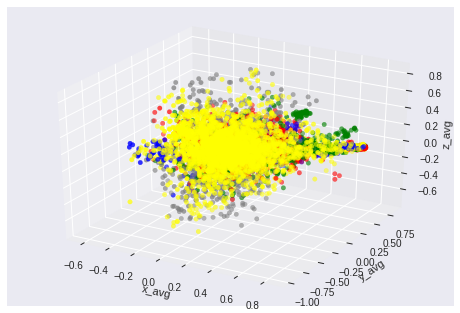

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['red','green','blue','yellow', 'grey']
color_labels = ['sitting', 'lying in bed', 'walking', 'standing', 'unknown']

ax.scatter(xs=accel_gyro_df['gyro_x_avg'],
           ys=accel_gyro_df['gyro_y_avg'],
           zs=accel_gyro_df['gyro_z_avg'],
           c=accel_gyro_df['action'],
           cmap=matplotlib.colors.ListedColormap(colors))

ax.set_xlabel('x_avg')
ax.set_ylabel('y_avg')
ax.set_zlabel('z_avg')

plt.show()

We put our dataset through the Principle Component Analysis to determine which features are the most important.

(7072, 24)

,accel_x_avg,accel_x_max,accel_x_min,accel_x_var,accel_y_avg,accel_y_max,accel_y_min,accel_y_var,accel_z_avg,accel_z_max,...,gyro_x_min,gyro_x_var,gyro_y_avg,gyro_y_max,gyro_y_min,gyro_y_var,gyro_z_avg,gyro_z_max,gyro_z_min,gyro_z_var
0,0.159138,0.234144,0.088988,0.000618,-0.969768,-0.947678,-0.979520,0.000033,0.181869,0.254380,...,-0.795273,0.109553,-0.013505,0.990044,-0.988045,0.666019,-0.001481,0.934011,-0.932445,0.238126
1,0.158557,0.234144,0.088988,0.000596,-0.969419,-0.947678,-0.979520,0.000031,0.184385,0.254380,...,-0.795273,0.116435,-0.113401,0.990044,-0.996475,0.647191,0.093231,0.934011,-0.932445,0.228795
2,0.155101,0.183332,0.088988,0.000241,-0.970612,-0.958764,-0.979520,0.000012,0.182566,0.244460,...,-0.795273,0.167084,-0.078202,0.990044,-0.996475,0.590006,-0.072593,0.829561,-0.932445,0.217608
3,0.158837,0.179128,0.141078,0.000046,-0.970036,-0.960780,-0.976552,0.000006,0.183465,0.220205,...,-0.518476,0.151276,-0.177618,0.990044,-0.996475,0.548300,0.067519,0.912871,-0.879049,0.231496
4,0.159664,0.171096,0.141078,0.000033,-0.969668,-0.966954,-0.972936,0.000002,0.184913,0.193310,...,-0.518476,0.127319,-0.121911,0.997054,-0.996475,0.544175,-0.021324,0.912871,-0.882258,0.245020


(7072, 23)

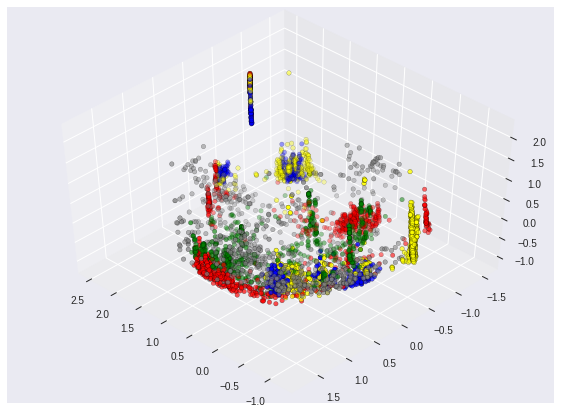

In [6]:
from sklearn import decomposition
from joblib import dump, load

X = accel_gyro_df.drop(['action', 'epoch_length', 'epoch_end', 'epoch_start'], axis=1)
y = accel_gyro_df.action.values

display(X.shape)
display(X.head())
fig = plt.figure()
plt.clf()
#ax = fig.add_subplot(111)
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components='mle', svd_solver='full')
#pca = decomposition.PCA(n_components=10)
pca.fit(X)
X = pca.transform(X)
display(X.shape)

dump(pca, 'mobilityAIPCAModel.joblib')

# for name, label in [('Sitting', 0), ('Lying in bed', 1), ('Walking', 2), ('Standing', 3)]:
#     ax.text3D(X[y == label, 0].mean(),
#               X[y == label, 1].mean() + 1.5,
#               X[y == label, 2].mean(),
#               X[y == label, 3].mean(), name,
#               horizontalalignment='center',
#               bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    
ax.scatter(X[:, 0], X[:, 1], X[:,2], c=y, cmap=matplotlib.colors.ListedColormap(colors),
           edgecolor='k')

#ax.xaxis.set_ticklabels([])
#ax.yaxis.set_ticklabels([])
#ax.w_zaxis.set_ticklabels([])

plt.show()

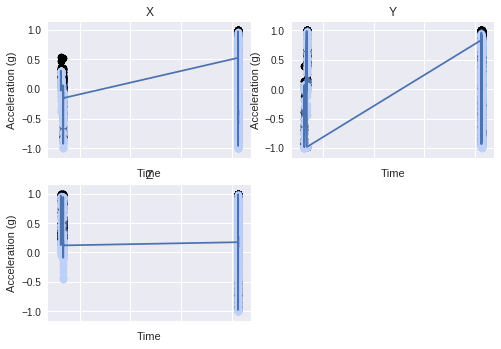

In [7]:
fig = plt.figure()
ax = fig.add_subplot(221)
ay = fig.add_subplot(222)
az = fig.add_subplot(223)

ax.scatter(accel_gyro_df['epoch_start'], accel_gyro_df['accel_x_max'],c="#000000")
ax.scatter(accel_gyro_df['epoch_start'], accel_gyro_df['accel_x_avg'])
ax.plot(accel_gyro_df['epoch_start'], accel_gyro_df['accel_x_avg'])
ax.scatter(accel_gyro_df['epoch_start'], accel_gyro_df['accel_x_min'],c="#bdd0f9")
ax.set_title('X')
ax.set_xticklabels([])
ax.set_ylabel('Acceleration (g)')
ax.set_xlabel('Time')

ay.scatter(accel_gyro_df['epoch_start'], accel_gyro_df['accel_y_max'],c="#000000")
ay.scatter(accel_gyro_df['epoch_start'], accel_gyro_df['accel_y_avg'])
ay.plot(accel_gyro_df['epoch_start'], accel_gyro_df['accel_y_avg'])
ay.scatter(accel_gyro_df['epoch_start'], accel_gyro_df['accel_y_min'],c="#bdd0f9")
ay.set_title('Y')
ay.set_xticklabels([])
ay.set_ylabel('Acceleration (g)')
ay.set_xlabel('Time')

az.scatter(accel_gyro_df['epoch_start'], accel_gyro_df['accel_z_max'],c="#000000")
az.scatter(accel_gyro_df['epoch_start'], accel_gyro_df['accel_z_avg'])
az.plot(accel_gyro_df['epoch_start'], accel_gyro_df['accel_z_avg'])
az.scatter(accel_gyro_df['epoch_start'], accel_gyro_df['accel_z_min'],c="#bdd0f9")
az.set_title('Z')
az.set_xticklabels([])
az.set_ylabel('Acceleration (g)')
az.set_xlabel('Time')

plt.show()

In the following cells, we attempt to create multiple models fron our training data to evaluate the best possible model according to accuracy.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

#X = accel_gyro_df.drop(['action', 'epoch_length', 'epoch_end', 'epoch_start'], axis=1)
y = accel_gyro_df.action
#X = np.delete(X, [1], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(X_train, y_train)

display(knn.score(X_test, y_test))

predictions = knn.predict(X_test)

display(confusion_matrix(y_test,predictions))


display(classification_report(y_test,predictions))




0.9406108597285068

array([[303,   2,   3,   4,   2],
       [  9, 184,   0,   0,  13],
       [  1,   0, 116,   2,   0],
       [  8,   4,  21, 885,   1],
       [ 20,   9,   3,   3, 175]])

'              precision    recall  f1-score   support\n\n           0       0.89      0.96      0.93       314\n           1       0.92      0.89      0.91       206\n           2       0.81      0.97      0.89       119\n           3       0.99      0.96      0.98       919\n           4       0.92      0.83      0.87       210\n\n   micro avg       0.94      0.94      0.94      1768\n   macro avg       0.91      0.93      0.91      1768\nweighted avg       0.94      0.94      0.94      1768\n'

In [9]:
from sklearn import svm

#X = accel_gyro_df.drop(['action', 'epoch_length', 'epoch_end', 'epoch_start'], axis=1)
#y = accel_gyro_df.action
#X = np.delete(X, [1], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Uses the "one vs one" multiclassification approach
svm = svm.SVC(decision_function_shape='ovr')
svm.fit(X_train, y_train)

display(svm.score(X_test, y_test))

predictions = svm.predict(X_test)

display(confusion_matrix(y_test,predictions))

display(classification_report(y_test,predictions))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8733031674208145

array([[264,   7,   4,  12,  27],
       [ 24, 137,   0,   0,  45],
       [  5,   0,  88,  26,   0],
       [ 30,   0,  12, 876,   1],
       [ 27,   1,   0,   3, 179]])

'              precision    recall  f1-score   support\n\n           0       0.75      0.84      0.80       314\n           1       0.94      0.67      0.78       206\n           2       0.85      0.74      0.79       119\n           3       0.96      0.95      0.95       919\n           4       0.71      0.85      0.77       210\n\n   micro avg       0.87      0.87      0.87      1768\n   macro avg       0.84      0.81      0.82      1768\nweighted avg       0.88      0.87      0.87      1768\n'

In [10]:
from sklearn.linear_model import Perceptron

#X = accel_gyro_df.drop(['action', 'epoch_length', 'epoch_end', 'epoch_start'], axis=1)
#y = accel_gyro_df.action

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = Perceptron(tol=1e-3, random_state=0)

clf.fit(X_train, y_train)

display(clf.score(X_test, y_test))

predictions = clf.predict(X_test)

display(confusion_matrix(y_test,predictions))

display(classification_report(y_test,predictions))

0.7505656108597285

array([[144,  41,   8,  97,  24],
       [ 14, 153,   0,  10,  29],
       [  0,   0,  39,  70,  10],
       [  7,   3,  12, 856,  41],
       [ 16,  29,   3,  27, 135]])

'              precision    recall  f1-score   support\n\n           0       0.80      0.46      0.58       314\n           1       0.68      0.74      0.71       206\n           2       0.63      0.33      0.43       119\n           3       0.81      0.93      0.87       919\n           4       0.56      0.64      0.60       210\n\n   micro avg       0.75      0.75      0.75      1768\n   macro avg       0.69      0.62      0.64      1768\nweighted avg       0.75      0.75      0.74      1768\n'

In [11]:
from sklearn.neural_network import MLPClassifier

#X = accel_gyro_df.drop(['action', 'epoch_length', 'epoch_end', 'epoch_start'], axis=1)
#y = accel_gyro_df.action

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#mlp = MLPClassifier(solver='lbfgs', alpha=0.05, hidden_layer_sizes=(50,), activation='tanh', learning_rate='constant')
mlp = MLPClassifier(solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(100,), activation='tanh', learning_rate='adaptive')

mlp.fit(X_train, y_train)

display(mlp.score(X_test, y_test))

predictions = mlp.predict(X_test)

display(confusion_matrix(y_test,predictions))

display(classification_report(y_test,predictions))

#output the model
dump(mlp, 'mobilityAIModel.joblib')

plt.show()


0.9434389140271493

array([[298,   3,   5,   3,   5],
       [  8, 174,   0,   1,  23],
       [  1,   0, 110,   8,   0],
       [ 13,   6,   8, 891,   1],
       [  8,   7,   0,   0, 195]])

'              precision    recall  f1-score   support\n\n           0       0.91      0.95      0.93       314\n           1       0.92      0.84      0.88       206\n           2       0.89      0.92      0.91       119\n           3       0.99      0.97      0.98       919\n           4       0.87      0.93      0.90       210\n\n   micro avg       0.94      0.94      0.94      1768\n   macro avg       0.92      0.92      0.92      1768\nweighted avg       0.94      0.94      0.94      1768\n'

Here we load the validation set. We validate our model using a 'leave-one-out' strategy. We run the validation set through the same steps as the model (normalization, windowify, merging, PCA) and finally evaluate the accuracy accordnig to the most accurate model.

(707, 23)

(707,)

0.8472418670438473

array([[163,   3,   1,   0,  18],
       [  0,  98,   1,   0,  15],
       [  0,   0,  56,   0,   1],
       [  1,   0,   7, 155,   0],
       [ 44,  16,   1,   0, 127]])

'              precision    recall  f1-score   support\n\n           0       0.78      0.88      0.83       185\n           1       0.84      0.86      0.85       114\n           2       0.85      0.98      0.91        57\n           3       1.00      0.95      0.97       163\n           4       0.79      0.68      0.73       188\n\n   micro avg       0.85      0.85      0.85       707\n   macro avg       0.85      0.87      0.86       707\nweighted avg       0.85      0.85      0.85       707\n'

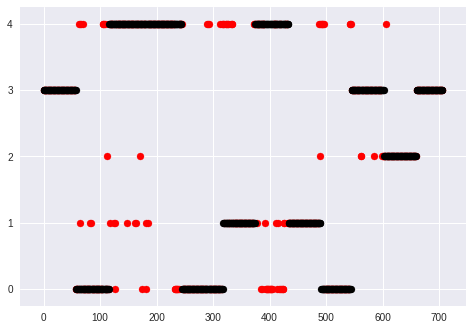

array([[158,   3,   1,   0,  23],
       [  0,  98,   1,   0,  15],
       [  0,   0,  56,   0,   1],
       [  1,   0,   7, 155,   0],
       [ 33,  16,   1,   0, 138]])

'              precision    recall  f1-score   support\n\n           0       0.82      0.85      0.84       185\n           1       0.84      0.86      0.85       114\n           2       0.85      0.98      0.91        57\n           3       1.00      0.95      0.97       163\n           4       0.78      0.73      0.76       188\n\n   micro avg       0.86      0.86      0.86       707\n   macro avg       0.86      0.88      0.87       707\nweighted avg       0.86      0.86      0.86       707\n'

'\n\n    0: Sitting\n    1: Lying in bed\n    2: Walking\n    3: Standing\n    4: Unknown\n\n'

In [12]:
"""
Load in seperate dataset and see how similar it is to what our model predicts

This can probably be modularized
"""

"""
###### THIS IS OLD STUFF #####

becca_accel_csv = create_training_set(root,["round-2/start/accel/new-berto-test-1-accel-start.csv"])
becca_accel_csv = becca_accel_csv.sort_values(by=['epoch (ms)'])
becca_accel2 = preprocessing.normalize(becca_accel_csv[['x-axis (g)','y-axis (g)','z-axis (g)']])
becca_accel_data = np.concatenate((becca_accel_csv[['epoch (ms)', 'elapsed (s)', 'state']], becca_accel2), axis=1)
becca_accel_df = pd.DataFrame(data=becca_accel_data[0:,0:],    # values
              index=[i for i in range(1, len(becca_accel_data) + 1)],    # 1st column as index
              columns=['epoch (ms)', 'elapsed (s)', 'state', 'x-axis (g)','y-axis (g)','z-axis (g)'])
display(becca_accel_df['epoch (ms)'].count())
#display(becca_accel_df.head(10))


#Load gyroscope data
display("Gyroscope data")
becca_gyro_csv = create_training_set(root,["round-2/start/gyro/new-berto-test-1-gyro-start.csv"])
becca_gyro_csv = becca_gyro_csv.sort_values(by=['epoch (ms)'])
becca_gyro2 = preprocessing.normalize(becca_gyro_csv[['x-axis (deg/s)', 'y-axis (deg/s)', 'z-axis (deg/s)']])
becca_gyro_data = np.concatenate((becca_gyro_csv[['epoch (ms)', 'elapsed (s)', 'state']], becca_gyro2), axis=1)
becca_gyro_df = pd.DataFrame(data=becca_gyro_data[0:,0:],    # values
              index=[i for i in range(1, len(becca_gyro_data) + 1)],    # 1st column as index
              columns=['epoch (ms)', 'elapsed (s)', 'state', 'x-axis (deg/s)','y-axis (deg/s)','z-axis (deg/s)'])
display(becca_gyro_df['epoch (ms)'].count())
#display(becca_gyro_df.head(10))

becca_accel_df = pd.DataFrame.from_records(windowify(2500, 500, becca_accel_df, accelerometer_stats))
becca_gyro_df = pd.DataFrame.from_records(windowify(2500, 500, becca_gyro_df, gyroscope_stats))
"""
becca_accel_df = load_accel_data(root, ["round-2/start/accel/new-berto-test-1-accel-start.csv"])
becca_gyro_df = load_gyro_data(root, ["round-2/start/gyro/new-berto-test-1-gyro-start.csv"])


becca_accel_gyro_df = performMerge(becca_accel_df,becca_gyro_df)

newX = becca_accel_gyro_df.drop(['action', 'epoch_length', 'epoch_end', 'epoch_start'], axis=1)
newY = becca_accel_gyro_df.action.values
clf = mlp

hyperparameter_tuning = False

if hyperparameter_tuning:
  from sklearn.neural_network import MLPClassifier
  mlp = MLPClassifier()

  parameter_space = {
      'hidden_layer_sizes': [(23,25), (23,), (50,), (100,)],
      'activation': ['identity', 'logistic', 'tanh', 'relu'],
      'solver': ['lbfgs', 'sgd', 'adam'],
      'alpha': [0.0001, 0.05, 0.001, 0.01],
      'learning_rate': ['constant','adaptive', 'invscaling'],
  }

  from sklearn.model_selection import GridSearchCV



  clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
  clf.fit(X_train, y_train)

  # Best parameter set
  print('Best parameters found:\n', clf.best_params_)

  # All results
  means = clf.cv_results_['mean_test_score']
  stds = clf.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, clf.cv_results_['params']):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

#pca.fit(newX)
newX = pca.transform(newX)
display(newX.shape)
display(newY.shape)

display(clf.score(newX, newY))
predictions = clf.predict(newX)

display(confusion_matrix(newY,predictions))

display(classification_report(newY,predictions))

xRow = [x for x in range(0, becca_accel_gyro_df['epoch_start'].count())]

ax.set_yticklabels(['Sitting', 'Lying in bed', 'Walking', 'Standing', 'Unknown'])

def confidence_filter(row):
  maxConfidence = max(row)
  cl = pd.Index(row).get_loc(maxConfidence)
  if maxConfidence < 0.95 and cl == 0:
    return 4
  return cl


test = pd.DataFrame(clf.predict_proba(newX))
test = test.apply(confidence_filter, axis=1)
#display(test)

fig = plt.figure()
ax = fig.add_subplot(111)

#ax.scatter(xRow, predictions, c="#00ff00")
ax.scatter(xRow, test, c="#ff0000")
ax.scatter(xRow, newY, c="#000000")

plt.show()

display(confusion_matrix(newY,test))
display(classification_report(newY,test))

"""

    0: Sitting
    1: Lying in bed
    2: Walking
    3: Standing
    4: Unknown

"""